# End-to-end (pure Python) pipeline: Type-3 clone dataset → compile/decompile → AST graphs → embeddings → GNN training

This notebook runs the full pipeline **without using any `python -m ...cli` commands**. It builds program artifacts from the **synthetic Code-Clone dataset** (`base/`, `type-1/2/3/`), generates method graphs from **decompiled** code, embeds nodes with **GraphCodeBERT**, and trains a small **graph encoder + program pooling + pair classifier**.

Notes:
- Uses Tree-sitter Java for parsing and a lightweight graph schema: **SEQ**, **AST**, **IF_THEN**, **IF_ELSE**.
- Uses a small message-passing GNN implemented directly in PyTorch (no PyG dependency).
- You can switch to training on original source instead of decompiled by toggling `USE_DECOMPILED`.


In [1]:

from __future__ import annotations

import os
import re
import json
import time
import hashlib
import random
import shutil
import subprocess
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Any, Dict, Iterator, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel

from tree_sitter import Language, Parser
import tree_sitter_java


/Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Configuration

In [2]:

# ---- Dataset ----
DATASET_ROOT = Path("../data/code-clone-dataset/dataset").expanduser().resolve()
CLONE_TYPE = "type-3"       # "type-1" | "type-2" | "type-3"
LIMIT_INDICES: Optional[int] = 10   # set None for all
SEED = 0

# ---- Tools ----
JDK_HOME = Path(os.environ.get("JAVA_HOME", "")).expanduser()
VINEFLOWER_JAR = Path("../chatgpt/vineflower-1.11.2.jar").expanduser().resolve()

# ---- Output ----
OUT_DIR = Path("./nb_program_artifacts_type3").resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- Embedding model ----
MODEL_NAME = "microsoft/graphcodebert-base"
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
MAX_LENGTH = 256
BATCH_SIZE = 32

# ---- Pipeline toggles ----
USE_DECOMPILED = True      # If True: compile->jar->decompile and graph decompiled java
FORCE_REBUILD = False      # If True: delete and rebuild existing program artifacts

print("DATASET_ROOT:", DATASET_ROOT)
print("OUT_DIR     :", OUT_DIR)
print("DEVICE      :", DEVICE)


DATASET_ROOT: /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/data/code-clone-dataset/dataset
OUT_DIR     : /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/pipeline/nb_program_artifacts_type3
DEVICE      : mps


## 2) Dataset enumeration and pair generators

In [3]:

def list_indices(root: Path) -> List[str]:
    base = root / "base"
    idxs = []
    for p in sorted(base.iterdir()):
        if p.is_dir():
            idxs.append(p.name)
    return idxs

def anchor_path(root: Path, idx: str) -> Path:
    return root / "base" / idx / "main.java"

def clone_paths(root: Path, idx: str, clone_type: str) -> List[Path]:
    d = root / clone_type / idx
    if not d.exists():
        return []
    return sorted(d.glob("*.java"))

def positive_pairs(*, root: Path, clone_type: str, seed: int = 0,
                   limit_indices: Optional[int] = None, infinite: bool = True) -> Iterator[Tuple[str,str,int]]:
    rng = random.Random(seed)
    idxs = list_indices(root)
    if limit_indices is not None:
        idxs = idxs[:limit_indices]
    per = []
    for idx in idxs:
        a = anchor_path(root, idx)
        cs = clone_paths(root, idx, clone_type)
        if a.exists() and cs:
            per.append((idx, a, cs))
    if not per:
        raise RuntimeError("No positive pairs found. Check DATASET_ROOT/CLONE_TYPE.")
    while True:
        idx, a, cs = rng.choice(per)
        b = rng.choice(cs)
        yield (str(a), str(b), 1)
        if not infinite:
            return

def negative_pairs(*, root: Path, clone_type: str, seed: int = 0,
                   limit_indices: Optional[int] = None, infinite: bool = True) -> Iterator[Tuple[str,str,int]]:
    rng = random.Random(seed + 12345)
    idxs = list_indices(root)
    if limit_indices is not None:
        idxs = idxs[:limit_indices]
    anchors = [(idx, anchor_path(root, idx)) for idx in idxs]
    anchors = [(idx, p) for idx,p in anchors if p.exists()]
    clone_pool = []
    for idx in idxs:
        for p in clone_paths(root, idx, clone_type):
            if p.exists():
                clone_pool.append((idx, p))
    if not anchors or not clone_pool:
        raise RuntimeError("No negative pools found.")
    while True:
        idx_a, a = rng.choice(anchors)
        while True:
            idx_b, b = rng.choice(clone_pool)
            if idx_b != idx_a:
                break
        yield (str(a), str(b), 0)
        if not infinite:
            return

def interleave(pos_it, neg_it, pos_ratio: float = 0.5, seed: int = 0) -> Iterator[Tuple[str,str,int]]:
    rng = random.Random(seed)
    while True:
        if rng.random() < pos_ratio:
            yield next(pos_it)
        else:
            yield next(neg_it)

# Preview
pos = positive_pairs(root=DATASET_ROOT, clone_type=CLONE_TYPE, seed=SEED, limit_indices=LIMIT_INDICES)
neg = negative_pairs(root=DATASET_ROOT, clone_type=CLONE_TYPE, seed=SEED, limit_indices=LIMIT_INDICES)
mix = interleave(pos, neg, pos_ratio=0.5, seed=SEED)

for i in range(5):
    a,b,y = next(mix)
    print(i, y, a, "->", b)


0 0 /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/data/code-clone-dataset/dataset/base/07/main.java -> /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/data/code-clone-dataset/dataset/type-3/08/3.java
1 0 /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/data/code-clone-dataset/dataset/base/01/main.java -> /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/data/code-clone-dataset/dataset/type-3/09/3.java
2 1 /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/data/code-clone-dataset/dataset/base/07/main.java -> /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/data/code-clone-dataset/dataset/type-3/07/2.java
3 1 /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/data/code-clone-dataset/dataset/base/01/main.java -> /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/data/code-clone-dataset/dataset/type-3/01/2.java
4 0 /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/data/code-clone-dataset/dataset/base/05/m

## 3) Java compile + jar + decompile helpers

In [4]:

CLASS_RE = re.compile(r"public\s+class\s+([A-Za-z_]\w*)")

def detect_public_class_name(java_text: str) -> Optional[str]:
    m = CLASS_RE.search(java_text)
    return m.group(1) if m else None

def sha1(s: str) -> str:
    return hashlib.sha1(s.encode("utf-8")).hexdigest()

def run(cmd: List[str], cwd: Optional[Path] = None, timeout: int = 300) -> Tuple[int,str,str]:
    p = subprocess.run(
        cmd,
        cwd=str(cwd) if cwd else None,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        timeout=timeout,
    )
    return p.returncode, p.stdout, p.stderr

def compile_single_java(java_path: Path, work_dir: Path, jdk_home: Path, extra_javac: Optional[List[str]] = None) -> Path:
    work_dir.mkdir(parents=True, exist_ok=True)
    src_dir = work_dir / "src"
    cls_dir = work_dir / "classes"
    src_dir.mkdir(parents=True, exist_ok=True)
    cls_dir.mkdir(parents=True, exist_ok=True)

    text = java_path.read_text(encoding="utf-8", errors="replace")
    cls = detect_public_class_name(text) or java_path.stem
    target_java = src_dir / f"{cls}.java"
    target_java.write_text(text, encoding="utf-8")

    javac = (jdk_home / "bin" / "javac") if jdk_home and (jdk_home / "bin" / "javac").exists() else Path("javac")
    flags = ["-g", "-encoding", "UTF-8", "-d", str(cls_dir)]
    if extra_javac:
        flags.extend(extra_javac)

    rc, out, err = run([str(javac), *flags, str(target_java)], cwd=work_dir, timeout=300)
    if rc != 0:
        raise RuntimeError(f"javac failed\n{err}\n")

    jar = (jdk_home / "bin" / "jar") if jdk_home and (jdk_home / "bin" / "jar").exists() else Path("jar")
    jar_path = work_dir / "app.jar"
    rc, out, err = run([str(jar), "--create", "--file", str(jar_path), "-C", str(cls_dir), "."], cwd=work_dir, timeout=300)
    if rc != 0:
        raise RuntimeError(f"jar failed\n{err}\n")
    return jar_path

def decompile_jar(jar_path: Path, out_dir: Path, vineflower_jar: Path) -> Path:
    out_dir.mkdir(parents=True, exist_ok=True)
    rc, out, err = run(["java", "-jar", str(vineflower_jar), str(jar_path), str(out_dir)], cwd=out_dir, timeout=300)
    if rc != 0:
        raise RuntimeError(f"vineflower failed\n{err}\n")
    return out_dir


## 4) Tree-sitter Java parser + lightweight AST graph builder

In [5]:

JAVA_LANGUAGE = Language(tree_sitter_java.language())
parser = Parser(JAVA_LANGUAGE)

CONTROL_NODES = {
    "if_statement","for_statement","while_statement","do_statement","switch_statement",
    "try_statement","catch_clause",
}
STRAIGHT_NODES = {
    "local_variable_declaration","expression_statement","return_statement","throw_statement",
}

EDGE_TYPE_TO_ID = {"SEQ":0, "AST":1, "IF_THEN":2, "IF_ELSE":3}

def _safe_text(code_bytes: bytes, node) -> str:
    return code_bytes[node.start_byte:node.end_byte].decode("utf-8", errors="replace").strip()

def extract_control_header(code: bytes, node) -> str:
    for child in node.children:
        if child.type in ("condition", "parenthesized_expression"):
            return code[child.start_byte:child.end_byte].decode("utf-8", errors="replace").strip()
    text = code[node.start_byte:node.end_byte].decode("utf-8", errors="replace")
    return text.split("{")[0].strip()

@dataclass
class GraphNode:
    id: int
    kind: str               # "control" | "straight"
    ast_type: str
    code: str
    start_byte: int
    end_byte: int
    depth: int

@dataclass
class GraphEdge:
    src: int
    dst: int
    type: str               # SEQ | AST | IF_THEN | IF_ELSE

def build_method_graph(java_source: str) -> Dict[str, Any]:
    code_bytes = java_source.encode("utf-8")
    tree = parser.parse(code_bytes)

    nodes: List[GraphNode] = []
    edges: List[GraphEdge] = []
    next_id = 0
    span_to_gid: Dict[Tuple[int,int,str], int] = {}

    def add_node(ts_node, depth: int) -> Optional[int]:
        nonlocal next_id
        t = ts_node.type
        is_control = t in CONTROL_NODES
        is_straight = t in STRAIGHT_NODES
        if not (is_control or is_straight):
            return None
        if is_control:
            code = extract_control_header(code_bytes, ts_node)
            kind = "control"
        else:
            code = _safe_text(code_bytes, ts_node)
            kind = "straight"
        if not code:
            return None
        gid = next_id; next_id += 1
        nodes.append(GraphNode(
            id=gid, kind=kind, ast_type=t, code=code,
            start_byte=ts_node.start_byte, end_byte=ts_node.end_byte, depth=depth
        ))
        span_to_gid[(ts_node.start_byte, ts_node.end_byte, ts_node.type)] = gid
        return gid

    stack: List[Tuple[Any,int,Optional[int]]] = [(tree.root_node, 0, None)]
    while stack:
        ts_node, depth, parent_sel = stack.pop()
        cur = add_node(ts_node, depth)
        next_parent = parent_sel
        if cur is not None:
            if parent_sel is not None:
                edges.append(GraphEdge(parent_sel, cur, "AST"))
                edges.append(GraphEdge(cur, parent_sel, "AST"))
            next_parent = cur
        for ch in reversed(ts_node.children):
            if len(ch.children) == 0 and ch.type in (";", "{", "}", "(", ")", ","):
                continue
            stack.append((ch, depth+1, next_parent))

    if len(nodes) >= 2:
        top_depth = min(n.depth for n in nodes)
        top_nodes = [n for n in nodes if n.depth == top_depth]
        top_nodes.sort(key=lambda n: (n.start_byte, n.end_byte))
        for a,b in zip(top_nodes, top_nodes[1:]):
            edges.append(GraphEdge(a.id, b.id, "SEQ"))
            edges.append(GraphEdge(b.id, a.id, "SEQ"))

    stack = [tree.root_node]
    while stack:
        ts_node = stack.pop()
        if ts_node.type == "if_statement":
            if_id = span_to_gid.get((ts_node.start_byte, ts_node.end_byte, ts_node.type))
            if if_id is not None:
                then_node = ts_node.child_by_field_name("consequence")
                else_node = ts_node.child_by_field_name("alternative")

                def selected_in_span(s: int, e: int) -> List[int]:
                    out = []
                    for n in nodes:
                        if n.start_byte >= s and n.end_byte <= e:
                            out.append(n.id)
                    return out

                if then_node is not None:
                    for tid in selected_in_span(then_node.start_byte, then_node.end_byte):
                        if tid == if_id: 
                            continue
                        edges.append(GraphEdge(if_id, tid, "IF_THEN"))
                        edges.append(GraphEdge(tid, if_id, "IF_THEN"))

                if else_node is not None:
                    for eid in selected_in_span(else_node.start_byte, else_node.end_byte):
                        if eid == if_id:
                            continue
                        edges.append(GraphEdge(if_id, eid, "IF_ELSE"))
                        edges.append(GraphEdge(eid, if_id, "IF_ELSE"))

        for ch in reversed(ts_node.children):
            if len(ch.children) == 0 and ch.type in (";", "{", "}", "(", ")", ","):
                continue
            stack.append(ch)

    return {
        "nodes": [asdict(n) for n in nodes],
        "edges": [asdict(e) for e in edges],
    }

def edges_to_tensors(edges: List[Dict[str,Any]]) -> Tuple[torch.Tensor, torch.Tensor]:
    src, dst, et = [], [], []
    for e in edges:
        t = e["type"]
        if t not in EDGE_TYPE_TO_ID:
            continue
        src.append(int(e["src"]))
        dst.append(int(e["dst"]))
        et.append(int(EDGE_TYPE_TO_ID[t]))
    if not src:
        return torch.zeros((2,0), dtype=torch.long), torch.zeros((0,), dtype=torch.long)
    return torch.tensor([src,dst], dtype=torch.long), torch.tensor(et, dtype=torch.long)

# Sanity test
demo = "class Demo{ int foo(int a,int b){ int x=a; if(a>b){x=x+1;} else {x=x-1;} return x; } }"
g = build_method_graph(demo)
ei, et = edges_to_tensors(g["edges"])
print("nodes:", len(g["nodes"]), "edges:", ei.shape[1], "edge_types:", sorted({e['type'] for e in g['edges']}))


nodes: 5 edges: 12 edge_types: ['AST', 'IF_ELSE', 'IF_THEN', 'SEQ']


## 5) Method extraction from a Java file (Tree-sitter)

In [6]:

def extract_methods(java_text: str) -> List[Tuple[str, str]]:
    code_bytes = java_text.encode("utf-8")
    tree = parser.parse(code_bytes)
    root = tree.root_node

    out: List[Tuple[str,str]] = []
    stack = [root]
    while stack:
        n = stack.pop()
        if n.type in ("method_declaration", "constructor_declaration"):
            name = None
            for ch in n.children:
                if ch.type == "identifier":
                    name = code_bytes[ch.start_byte:ch.end_byte].decode("utf-8", errors="replace")
                    break
            if name is None:
                name = n.type
            src = code_bytes[n.start_byte:n.end_byte].decode("utf-8", errors="replace")
            out.append((name, src))
        for ch in reversed(n.children):
            stack.append(ch)
    return out

def java_file_to_methods_jsonl(java_path: Path, out_jsonl: Path) -> int:
    text = java_path.read_text(encoding="utf-8", errors="replace")
    methods = extract_methods(text)
    if not methods:
        methods = [("FILE", text)]
    out_jsonl.parent.mkdir(parents=True, exist_ok=True)
    n_written = 0
    with out_jsonl.open("w", encoding="utf-8") as f:
        for i,(mname, msrc) in enumerate(methods):
            g = build_method_graph(msrc)
            rec = {
                "method_id": f"{java_path}:{mname}:{i}",
                "method_name": mname,
                "file": str(java_path),
                "nodes": [
                    {
                        "id": n["id"],
                        "kind": n["kind"],
                        "ast_type": n["ast_type"],
                        "code": n["code"],
                        "start_byte": n["start_byte"],
                        "end_byte": n["end_byte"],
                        "depth": n["depth"],
                    }
                    for n in g["nodes"]
                ],
                "edges": g["edges"],
            }
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")
            n_written += 1
    return n_written


## 6) Build per-program artifacts (compile/decompile → methods.jsonl → embed_shard.pt)

In [7]:

def pick_java_for_graph(program_src: Path, artifact_dir: Path) -> Path:
    if not USE_DECOMPILED:
        return program_src
    decomp_dir = artifact_dir / "decompiled"
    cands = sorted(decomp_dir.rglob("*.java"))
    return cands[0] if cands else program_src

def embed_methods_jsonl(in_jsonl: Path, out_pt: Path, model, tokenizer, device: str,
                        max_length: int = 256, batch_size: int = 32) -> int:
    recs = []
    parsed = [json.loads(l) for l in in_jsonl.read_text(encoding="utf-8").splitlines() if l.strip()]

    for rec in parsed:
        nodes = rec["nodes"]
        edges = rec["edges"]
        texts = [n["code"] for n in nodes]

        if not texts:
            edge_index, edge_type = edges_to_tensors(edges)
            recs.append({
                "method_id": rec["method_id"],
                "method_name": rec["method_name"],
                "file": rec["file"],
                "x": torch.zeros((0, 768), dtype=torch.float32),
                "edge_index": edge_index,
                "edge_type": edge_type,
                "num_nodes": 0,
                "num_edges": int(edge_index.shape[1]),
            })
            continue

        embs = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            tok = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
            tok = {k:v.to(device) for k,v in tok.items()}
            with torch.no_grad():
                out = model(**tok)
                last = out.last_hidden_state
                mask = tok["attention_mask"].unsqueeze(-1)
                pooled = (last * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
            embs.append(pooled.detach().cpu())
        x = torch.cat(embs, dim=0).to(torch.float32)

        edge_index, edge_type = edges_to_tensors(edges)
        recs.append({
            "method_id": rec["method_id"],
            "method_name": rec["method_name"],
            "file": rec["file"],
            "x": x,
            "edge_index": edge_index,
            "edge_type": edge_type,
            "num_nodes": int(x.shape[0]),
            "num_edges": int(edge_index.shape[1]),
        })

    out_pt.parent.mkdir(parents=True, exist_ok=True)
    torch.save(recs, out_pt)
    return len(recs)

def build_program_artifact(program_src: Path, out_root: Path,
                           jdk_home: Path, vineflower_jar: Path,
                           model, tokenizer, device: str,
                           extra_javac: Optional[List[str]] = None) -> Dict[str, Any]:
    prog_id = sha1(str(program_src))
    artifact_dir = out_root / f"prog_{prog_id}"

    if FORCE_REBUILD and artifact_dir.exists():
        shutil.rmtree(artifact_dir)
    artifact_dir.mkdir(parents=True, exist_ok=True)

    if USE_DECOMPILED:
        jar_path = artifact_dir / "app.jar"
        if not jar_path.exists():
            jar_path = compile_single_java(program_src, artifact_dir, jdk_home, extra_javac=extra_javac)
        decomp_dir = artifact_dir / "decompiled"
        if not decomp_dir.exists() or not any(decomp_dir.rglob("*.java")):
            decompile_jar(jar_path, decomp_dir, vineflower_jar)

    java_for_graph = pick_java_for_graph(program_src, artifact_dir)

    methods_jsonl = artifact_dir / "methods.jsonl"
    if not methods_jsonl.exists():
        n_methods = java_file_to_methods_jsonl(java_for_graph, methods_jsonl)
    else:
        n_methods = sum(1 for _ in methods_jsonl.open("r", encoding="utf-8"))

    shard_pt = artifact_dir / "embed_shard.pt"
    if not shard_pt.exists():
        n_rec = embed_methods_jsonl(methods_jsonl, shard_pt, model, tokenizer, device=device,
                                    max_length=MAX_LENGTH, batch_size=BATCH_SIZE)
    else:
        n_rec = len(torch.load(shard_pt, map_location="cpu"))

    return {
        "source_path": str(program_src),
        "artifact_dir": str(artifact_dir),
        "java_for_graph": str(java_for_graph),
        "methods_jsonl": str(methods_jsonl),
        "embed_shard": str(shard_pt),
        "num_methods": int(n_methods),
        "num_method_records": int(n_rec),
    }


## 7) Run artifact build for anchors + clones

In [8]:

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()

def iter_program_sources(root: Path, clone_type: str, limit_indices: Optional[int]) -> List[Path]:
    idxs = list_indices(root)
    if limit_indices is not None:
        idxs = idxs[:limit_indices]
    out: List[Path] = []
    for idx in idxs:
        a = anchor_path(root, idx)
        if a.exists():
            out.append(a)
        for c in clone_paths(root, idx, clone_type):
            if c.exists():
                out.append(c)
    seen, uniq = set(), []
    for p in out:
        s = str(p.resolve())
        if s not in seen:
            seen.add(s); uniq.append(p)
    return uniq

sources = iter_program_sources(DATASET_ROOT, CLONE_TYPE, LIMIT_INDICES)
print("Programs to process:", len(sources))

program_index: Dict[str, Any] = {"items": {}, "failures": []}
t0 = time.time()

for i, src in enumerate(sources, 1):
    try:
        item = build_program_artifact(
            src, OUT_DIR,
            jdk_home=JDK_HOME,
            vineflower_jar=VINEFLOWER_JAR,
            model=model, tokenizer=tokenizer, device=DEVICE,
            extra_javac=None,  # add flags later
        )
        program_index["items"][str(Path(src).resolve())] = item
    except Exception as e:
        program_index["failures"].append({"source_path": str(src), "error": str(e)})
    if i % 5 == 0:
        print(f"[{i}/{len(sources)}] ok={len(program_index['items'])} fail={len(program_index['failures'])}")

program_index_path = OUT_DIR / "program_index.json"
program_index_path.write_text(json.dumps(program_index, indent=2, ensure_ascii=False), encoding="utf-8")

print("Wrote:", program_index_path)
print("Done in %.1fs" % (time.time()-t0))
print("OK:", len(program_index["items"]), "FAILED:", len(program_index["failures"]))


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1903.99it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: microsoft/graphcodebert-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.decoder.bias            | UNEXPECTED | 
lm_head.decoder.weight          | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training 

Programs to process: 40
[5/40] ok=5 fail=0
[10/40] ok=10 fail=0
[15/40] ok=15 fail=0
[20/40] ok=20 fail=0
[25/40] ok=25 fail=0
[30/40] ok=30 fail=0
[35/40] ok=35 fail=0
[40/40] ok=40 fail=0
Wrote: /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/pipeline/nb_program_artifacts_type3/program_index.json
Done in 0.1s
OK: 40 FAILED: 0


## 8) Program store loader

In [9]:

def load_program_methods(program_index: Dict[str,Any], program_src: str) -> Optional[List[Dict[str,Any]]]:
    item = program_index["items"].get(str(Path(program_src).resolve()))
    if not item:
        return None
    shard = Path(item["embed_shard"])
    if not shard.exists():
        return None
    return torch.load(shard, map_location="cpu")

some_key = next(iter(program_index["items"].keys()))
methods = load_program_methods(program_index, some_key)
print("Example program:", some_key)
print("num_methods:", len(methods))
print("x shape:", methods[0]["x"].shape, "edge_index:", methods[0]["edge_index"].shape)


Example program: /Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/data/code-clone-dataset/dataset/base/01/main.java
num_methods: 6
x shape: torch.Size([1, 768]) edge_index: torch.Size([2, 0])


## 9) Simple GNN encoder + program pooling

In [10]:

def scatter_mean(src: torch.Tensor, index: torch.Tensor, dim_size: int) -> torch.Tensor:
    H = src.shape[-1]
    out = torch.zeros((dim_size, H), device=src.device, dtype=src.dtype)
    cnt = torch.zeros((dim_size, 1), device=src.device, dtype=src.dtype)
    out.index_add_(0, index, src)
    cnt.index_add_(0, index, torch.ones((index.shape[0],1), device=src.device, dtype=src.dtype))
    return out / cnt.clamp(min=1.0)

class SimpleGNN(nn.Module):
    def __init__(self, in_dim: int = 768, hidden: int = 256, layers: int = 3, dropout: float = 0.1):
        super().__init__()
        self.in_proj = nn.Linear(in_dim, hidden)
        self.layers = nn.ModuleList([nn.Linear(hidden, hidden) for _ in range(layers)])
        self.dropout = dropout

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        h = F.relu(self.in_proj(x))
        for lin in self.layers:
            if edge_index.numel() == 0 or h.shape[0] == 0:
                h = F.relu(lin(h))
                continue
            src, dst = edge_index[0], edge_index[1]
            agg = scatter_mean(h[src], dst, dim_size=h.shape[0])
            h = h + agg
            h = F.dropout(h, p=self.dropout, training=self.training)
            h = F.relu(lin(h))
        return h

def encode_method(gnn: SimpleGNN, rec: Dict[str,Any], device: str) -> torch.Tensor:
    x = rec["x"].to(device)
    ei = rec["edge_index"].to(device)
    if x.shape[0] == 0:
        return torch.zeros((gnn.in_proj.out_features,), device=device)
    h = gnn(x, ei)
    return h.mean(dim=0)

@torch.no_grad()
def encode_program_mean(gnn: SimpleGNN, method_recs: List[Dict[str,Any]], device: str) -> torch.Tensor:
    if not method_recs:
        return torch.zeros((gnn.in_proj.out_features,), device=device)
    embs = [encode_method(gnn, rec, device) for rec in method_recs]
    return torch.stack(embs, dim=0).mean(dim=0)

class PairClassifier(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.fc1 = nn.Linear(dim * 2, dim)
        self.fc2 = nn.Linear(dim, 1)

    def forward(self, ha: torch.Tensor, hb: torch.Tensor) -> torch.Tensor:
        feat = torch.cat([torch.abs(ha - hb), ha * hb], dim=-1)
        z = F.relu(self.fc1(feat))
        return self.fc2(z).squeeze(-1)


In [11]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, Iterator, List, Optional, Tuple

import math
import random
import torch
import torch.nn.functional as F

try:
    import matplotlib.pyplot as plt
except Exception:
    plt = None


def _auc_roc_from_scores(y_true: List[int], y_score: List[float]) -> Tuple[float, List[float], List[float]]:
    """
    Pure-python ROC AUC (no sklearn dependency).
    Returns: (auc, fpr_list, tpr_list)
    """
    assert len(y_true) == len(y_score) and len(y_true) > 0

    # Count positives/negatives
    p = sum(1 for y in y_true if y == 1)
    n = len(y_true) - p
    if p == 0 or n == 0:
        return float("nan"), [], []

    # Sort by score descending
    pairs = sorted(zip(y_score, y_true), key=lambda t: t[0], reverse=True)

    tp = 0
    fp = 0
    tpr = [0.0]
    fpr = [0.0]

    # Walk thresholds (at each unique score)
    last_score = None
    for score, y in pairs:
        if last_score is None:
            last_score = score

        # If score changed, record point before stepping into next threshold
        if score != last_score:
            tpr.append(tp / p)
            fpr.append(fp / n)
            last_score = score

        if y == 1:
            tp += 1
        else:
            fp += 1

    # Final point
    tpr.append(tp / p)
    fpr.append(fp / n)

    # Trapezoidal area
    auc = 0.0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i - 1]) * (tpr[i] + tpr[i - 1]) / 2.0

    return float(auc), fpr, tpr


@torch.no_grad()
def eval_stream_auc(
    gnn,
    clf,
    program_index: Dict[str, Any],
    pair_it: Iterator[Tuple[str, str, int]],
    device: str,
    num_pairs: int,
    *,
    plot: bool = False,
    title: str = "ROC (val)",
) -> Dict[str, Any]:
    """
    Evaluates `num_pairs` from pair_it.
    Returns val_loss, val_acc, auc, and bookkeeping counts.

    Uses y_score = sigmoid(logit) for ROC AUC.
    """
    gnn.eval()
    clf.eval()

    losses: List[torch.Tensor] = []
    y_true: List[int] = []
    y_score: List[float] = []

    used = 0
    pos = 0
    correct = 0

    for _ in range(num_pairs):
        a, b, y = next(pair_it)

        ma = load_program_methods(program_index, a)
        mb = load_program_methods(program_index, b)
        if ma is None or mb is None:
            continue

        ha = encode_program_mean(gnn, ma, device)
        hb = encode_program_mean(gnn, mb, device)

        logit = clf(ha, hb).view(())  # scalar
        target = torch.tensor(float(y), device=device)

        loss = F.binary_cross_entropy_with_logits(logit, target)
        prob = torch.sigmoid(logit).item()

        pred = 1 if prob >= 0.5 else 0
        correct += int(pred == int(y))

        used += 1
        pos += int(y == 1)
        losses.append(loss.detach().cpu())
        y_true.append(int(y))
        y_score.append(float(prob))

    if used == 0:
        return {
            "val_loss": None,
            "val_acc": None,
            "auc": None,
            "used": 0,
            "pos": 0,
            "neg": 0,
        }

    val_loss = float(torch.stack(losses).mean())
    val_acc = correct / used
    auc, fpr, tpr = _auc_roc_from_scores(y_true, y_score)

    if plot and plt is not None and fpr and tpr and not math.isnan(auc):
        plt.figure()
        plt.plot(fpr, tpr)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{title} | AUC={auc:.3f} | used={used} pos={pos} neg={used-pos}")
        plt.grid(True)
        plt.show()

    return {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "auc": auc if not math.isnan(auc) else None,
        "used": used,
        "pos": pos,
        "neg": used - pos,
    }

## 10) Training loop (program-level)

In [12]:

@dataclass
class TrainCfg:
    steps: int = 2000
    batch_pairs: int = 32
    lr: float = 1e-3
    weight_decay: float = 1e-4
    log_every: int = 50
    eval_every: int = 200
    val_pairs: int = 200
    pos_ratio: float = 0.5
    hidden: int = 256
    layers: int = 3
    dropout: float = 0.1
    val_ratio: float = 0.2

cfg = TrainCfg()

def batch_k(it: Iterator[Tuple[str,str,int]], k: int) -> List[Tuple[str,str,int]]:
    return [next(it) for _ in range(k)]

def eval_stream(gnn, clf, program_index, pair_it, device: str, num_pairs: int) -> Dict[str, Any]:
    gnn.eval(); clf.eval()
    losses = []
    correct = 0
    used = 0
    pos = 0
    for _ in range(num_pairs):
        a,b,y = next(pair_it)
        ma = load_program_methods(program_index, a)
        mb = load_program_methods(program_index, b)
        if ma is None or mb is None:
            continue
        ha = encode_program_mean(gnn, ma, device)
        hb = encode_program_mean(gnn, mb, device)
        logit = clf(ha, hb)
        target = torch.tensor(float(y), device=device)
        loss = F.binary_cross_entropy_with_logits(logit, target)
        prob = torch.sigmoid(logit).item()
        pred = 1 if prob >= 0.5 else 0
        correct += int(pred == int(y))
        pos += int(y == 1)
        used += 1
        losses.append(loss.detach().cpu())
    if used == 0:
        return {"val_loss": None, "val_acc": None, "used": 0, "pos": 0, "neg": 0}
    return {
        "val_loss": float(torch.stack(losses).mean()),
        "val_acc": correct / used,
        "used": used,
        "pos": pos,
        "neg": used - pos,
    }

def train_program_model(program_index: Dict[str,Any],
                        train_it: Iterator[Tuple[str,str,int]],
                        val_it: Iterator[Tuple[str,str,int]],
                        device: str,
                        cfg: TrainCfg):
    torch.manual_seed(SEED)
    random.seed(SEED)

    gnn = SimpleGNN(in_dim=768, hidden=cfg.hidden, layers=cfg.layers, dropout=cfg.dropout).to(device)
    clf = PairClassifier(dim=cfg.hidden).to(device)
    opt = torch.optim.AdamW(list(gnn.parameters()) + list(clf.parameters()), lr=cfg.lr, weight_decay=cfg.weight_decay)

    hist = []
    ema = None
    gnn.train(); clf.train()

    for step in range(1, cfg.steps + 1):
        batch = batch_k(train_it, cfg.batch_pairs)
        logits, targets = [], []
        for a,b,y in batch:
            ma = load_program_methods(program_index, a)
            mb = load_program_methods(program_index, b)
            if ma is None or mb is None:
                continue
            ha = encode_program_mean(gnn, ma, device)
            hb = encode_program_mean(gnn, mb, device)
            logits.append(clf(ha, hb))
            targets.append(torch.tensor(float(y), device=device))
        if not logits:
            continue

        logits_t = torch.stack(logits)
        targets_t = torch.stack(targets)
        loss = F.binary_cross_entropy_with_logits(logits_t, targets_t)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        l = float(loss.detach().cpu())
        ema = l if ema is None else 0.98 * ema + 0.02 * l

        if step % cfg.log_every == 0:
            print(f"step={step} loss={l:.4f} ema={ema:.4f}")

        if step % cfg.eval_every == 0:
            metrics = eval_stream_auc(
                gnn, clf, program_index, val_it,
                device=device,
                num_pairs=cfg.val_pairs,
                plot=False,               # set True to draw ROC every eval
                title=f"ROC at step {step}",
            )
            print(
                f"[VAL] used={metrics['used']} pos={metrics['pos']} neg={metrics['neg']} "
                f"val_loss={metrics['val_loss']} val_acc={metrics['val_acc']} auc={metrics['auc']}"
            )
            hist.append({"step": step, "train_loss": l, "ema": ema, **metrics})
            gnn.train(); clf.train()

    return gnn, clf, hist


## 11) Train/val split + training run

In [13]:

def extract_idx_from_synthetic_path(p: str) -> Optional[str]:
    parts = Path(p).parts
    for i, seg in enumerate(parts):
        if seg == "base" or seg.startswith("type-"):
            if i + 1 < len(parts):
                return parts[i+1]
    return None

def split_indices(idxs: List[str], val_ratio: float, seed: int) -> Tuple[set[str], set[str]]:
    rng = random.Random(seed)
    idxs = idxs[:]
    rng.shuffle(idxs)
    n_val = max(1, int(round(len(idxs) * val_ratio))) if idxs else 0
    val = set(idxs[:n_val])
    train = set(idxs[n_val:])
    return train, val

def filter_pairs_by_anchor_index(pair_it, allowed: set[str]) -> Iterator[Tuple[str,str,int]]:
    while True:
        a,b,y = next(pair_it)
        ia = extract_idx_from_synthetic_path(a)
        if ia is None:
            continue
        if ia in allowed:
            yield (a,b,y)

all_idxs = list_indices(DATASET_ROOT)
if LIMIT_INDICES is not None:
    all_idxs = all_idxs[:LIMIT_INDICES]

train_idxs, val_idxs = split_indices(all_idxs, val_ratio=cfg.val_ratio, seed=SEED)
print("train_idxs:", len(train_idxs), "val_idxs:", len(val_idxs))

pos = positive_pairs(root=DATASET_ROOT, clone_type=CLONE_TYPE, seed=SEED, limit_indices=LIMIT_INDICES)
neg = negative_pairs(root=DATASET_ROOT, clone_type=CLONE_TYPE, seed=SEED, limit_indices=LIMIT_INDICES)
mix = interleave(pos, neg, pos_ratio=cfg.pos_ratio, seed=SEED)

pos_v = positive_pairs(root=DATASET_ROOT, clone_type=CLONE_TYPE, seed=SEED+999, limit_indices=LIMIT_INDICES)
neg_v = negative_pairs(root=DATASET_ROOT, clone_type=CLONE_TYPE, seed=SEED+999, limit_indices=LIMIT_INDICES)
mix_v = interleave(pos_v, neg_v, pos_ratio=cfg.pos_ratio, seed=SEED+999)

train_it = filter_pairs_by_anchor_index(mix, train_idxs)
val_it = filter_pairs_by_anchor_index(mix_v, val_idxs)

gnn, clf, hist = train_program_model(program_index, train_it, val_it, device=DEVICE, cfg=cfg)

model_dir = OUT_DIR / "models"
model_dir.mkdir(parents=True, exist_ok=True)
torch.save(gnn.state_dict(), model_dir / "gnn.pt")
torch.save(clf.state_dict(), model_dir / "clf.pt")
(model_dir / "history.json").write_text(json.dumps(hist, indent=2), encoding="utf-8")

print("Saved models to:", model_dir)
print("History points:", len(hist))


train_idxs: 8 val_idxs: 2
step=50 loss=0.6179 ema=0.6615
step=100 loss=0.5230 ema=0.5926
step=150 loss=0.5616 ema=0.5319
step=200 loss=0.5326 ema=0.5138
[VAL] used=200 pos=99 neg=101 val_loss=0.4904137849807739 val_acc=0.755 auc=0.800980098009801
step=250 loss=0.4489 ema=0.5023
step=300 loss=0.3997 ema=0.4761
step=350 loss=0.5158 ema=0.4654
step=400 loss=0.4355 ema=0.4504
[VAL] used=200 pos=96 neg=104 val_loss=0.4218173325061798 val_acc=0.78 auc=0.8963341346153846
step=450 loss=0.4734 ema=0.4288
step=500 loss=0.3303 ema=0.4049
step=550 loss=0.4386 ema=0.3932
step=600 loss=0.2716 ema=0.3759
[VAL] used=200 pos=102 neg=98 val_loss=0.535530149936676 val_acc=0.68 auc=0.8373349339735896
step=650 loss=0.4560 ema=0.3612
step=700 loss=0.2745 ema=0.3651
step=750 loss=0.3722 ema=0.3421
step=800 loss=0.3061 ema=0.3128
[VAL] used=200 pos=92 neg=108 val_loss=0.5024121999740601 val_acc=0.805 auc=0.8596014492753622
step=850 loss=0.2008 ema=0.3068
step=900 loss=0.2904 ema=0.3018
step=950 loss=0.2488 em

## 12) Inspect last validation points

In [14]:

if hist:
    for r in hist[-5:]:
        print(r)
else:
    print("No eval points recorded yet.")


{'step': 1200, 'train_loss': 0.3435484766960144, 'ema': 0.2651319465204026, 'val_loss': 0.5261616706848145, 'val_acc': 0.83, 'auc': 0.9026228519746758, 'used': 200, 'pos': 107, 'neg': 93}
{'step': 1400, 'train_loss': 0.212834894657135, 'ema': 0.27757663397911636, 'val_loss': 0.36950814723968506, 'val_acc': 0.83, 'auc': 0.9394757903161265, 'used': 200, 'pos': 98, 'neg': 102}
{'step': 1600, 'train_loss': 0.3095071315765381, 'ema': 0.26437214597773917, 'val_loss': 0.485128790140152, 'val_acc': 0.86, 'auc': 0.9109198278450605, 'used': 200, 'pos': 103, 'neg': 97}
{'step': 1800, 'train_loss': 0.33893224596977234, 'ema': 0.2638259846502894, 'val_loss': 0.4041043519973755, 'val_acc': 0.825, 'auc': 0.9316290726817043, 'used': 200, 'pos': 95, 'neg': 105}
{'step': 2000, 'train_loss': 0.31572890281677246, 'ema': 0.2504228056128155, 'val_loss': 0.3720952570438385, 'val_acc': 0.825, 'auc': 0.9411764705882352, 'used': 200, 'pos': 98, 'neg': 102}


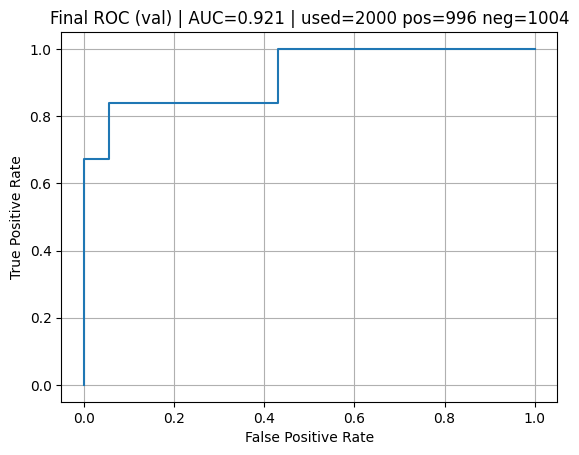

{'val_loss': 0.43469318747520447,
 'val_acc': 0.81,
 'auc': 0.9210457367317876,
 'used': 2000,
 'pos': 996,
 'neg': 1004}

In [15]:
# After training: fresh validation stream for final ROC/AUC
pos_v2 = positive_pairs(root=DATASET_ROOT, clone_type=CLONE_TYPE, seed=SEED+999, limit_indices=LIMIT_INDICES)
neg_v2 = negative_pairs(root=DATASET_ROOT, clone_type=CLONE_TYPE, seed=SEED+999, limit_indices=LIMIT_INDICES)
mix_v2 = interleave(pos_v2, neg_v2, pos_ratio=cfg.pos_ratio, seed=SEED+999)
val_it2 = filter_pairs_by_anchor_index(mix_v2, val_idxs)

final = eval_stream_auc(gnn, clf, program_index, val_it2, device=DEVICE, num_pairs=2000, plot=True, title="Final ROC (val)")
final